In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os
import matplotlib as mpl

In [2]:
run_name = 'baseline'
plots_path = f'../results/{run_name}/plots/'

In [3]:
trees = pd.read_csv(f'../data/reforestree/field_data.csv')

# Plot Carbon Distribution

In [ ]:
site = 'Manuel Macias RGB'
carbon_distribution = np.load('../data/dataset/sites/{}_carbon.npy'.format(site))
image = cv2.imread('../data/dataset/sites/{}_image.png'.format(site))
image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image_original = cv2.imread('../data/reforestree/wwf_ecuador/RGB Orthomosaics/{}.tif'.format(site))
image_original = np.array(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))

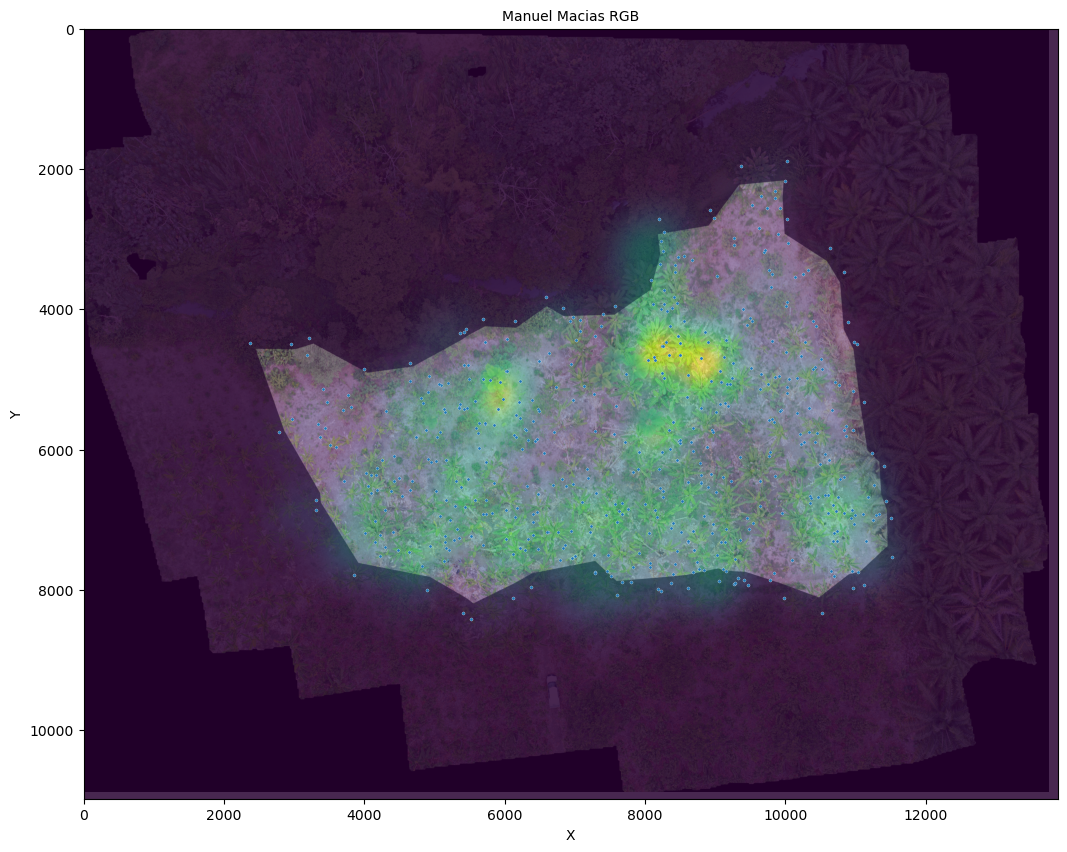

In [13]:
cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=0.01, vmax=5)
cmap.set_over('salmon')

plt.figure(figsize=(15,10))
ax = plt.gca()
ax.imshow(image_original)
ax.imshow(image, alpha=0.7)
ax.imshow(carbon_distribution, alpha=0.5, cmap=cmap)
sns.scatterplot(data=trees[trees.site == site], x="X", y="Y", legend=False, s=5, ax=ax)
ax.set_title(site, fontsize=10)
plt.show()

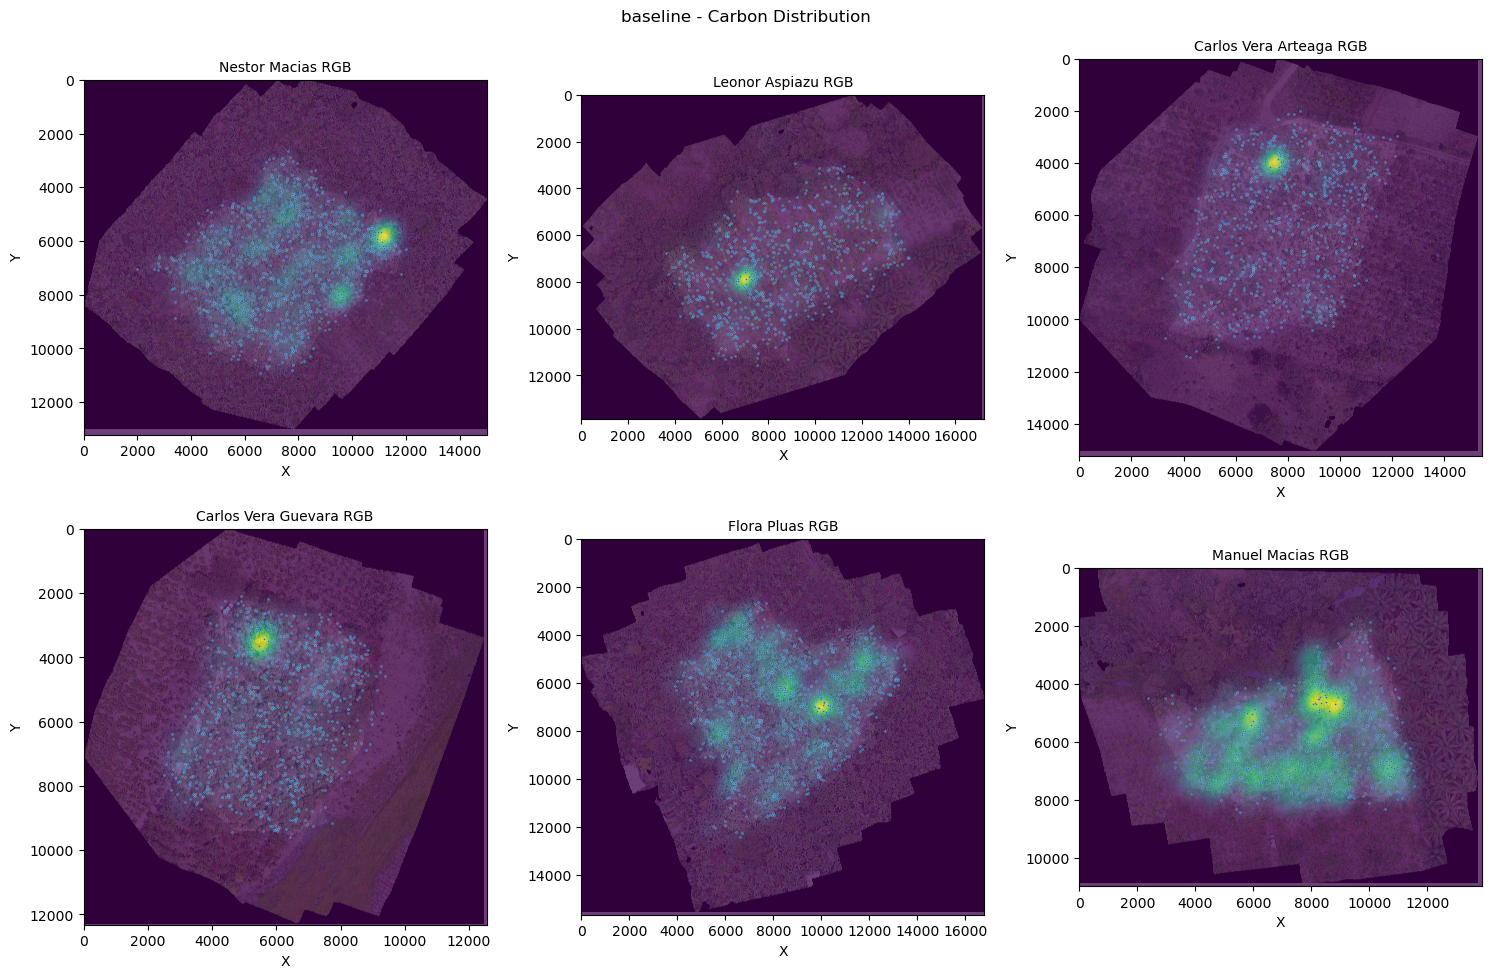

In [4]:
'''
fig, axs = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle(f"{run_name} - Carbon Distribution")

for site, ax in zip(trees.site.unique(), axs.flat):
    carbon_distribution = np.load('../data/dataset/sites/{}_carbon.npy'.format(site))
    image = cv2.imread('../data/dataset/sites/{}_image.png'.format(site))
    image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_original = cv2.imread('../data/reforestree/wwf_ecuador/RGB Orthomosaics/{}.tif'.format(site))
    image_original = np.array(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))

    ax.imshow(image_original)
    ax.imshow(image, alpha=0.2)
    ax.imshow(carbon_distribution, alpha=0.7)
    sns.scatterplot(data=trees[trees.site == site], x="X", y="Y", legend=False, s=2, ax=ax)
    ax.set_title(site, fontsize=10)

fig.tight_layout(pad=1)
plt.savefig(plots_path + "carbon_distribution.pdf", dpi=300)
plt.show()
'''

# Analyse patches

In [6]:
patches = pd.read_csv(f'../results/{run_name}/csv/predictions.csv', index_col=0)

In [7]:
patches = patches.rename(columns={"patch size": "patch_size"})
patches = patches.drop(columns=patches.columns[0], axis=1)

In [8]:
a = [np.flip(eval(site_index))*patch_size for site_index, patch_size in zip(patches.site_index, patches.patch_size)]
b = [np.array([a[0], a[1] + patch_size]) for a, patch_size in zip(a, patches.patch_size)]
c = [np.array([a[0] + patch_size, a[1] + patch_size]) for a, patch_size in zip(a, patches.patch_size)]
d = [np.array([a[0] + patch_size, a[1]]) for a, patch_size in zip(a, patches.patch_size)]
vertices = np.moveaxis(np.stack((a,b,c,d)), 0, 1).tolist()
patches["vertices"] = vertices

In [10]:
# get image shapes
images = {}
image_shapes = {}
for site in tqdm(trees.site.unique()):
    path = '../data/reforestree/wwf_ecuador/RGB Orthomosaics/{}.tif'.format(site)
    img = cv2.imread(path)
    img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    images[site] = img
    image_shapes[site] = img.shape

100%|██████████| 6/6 [00:22<00:00,  3.75s/it]


In [11]:
vertices_transformed_array = []
for idx, patch in patches.iterrows():
    angle = np.deg2rad(patch.rotation)
    A = np.array([[np.cos(angle), - np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    h = image_shapes[patch.site][0]
    w = image_shapes[patch.site][1]
    offset1 = np.array([w, h])
    w2 = int(np.dot(offset1, np.array([np.cos(angle), np.sin(angle)])))
    h2 = int(np.dot(offset1, np.array([np.sin(angle), np.cos(angle)])))
    offset2 = np.array([w2, h2])
    vertices_transformed = [np.dot(A, coordinate - 0.5 * offset1) + 0.5 * offset1 for coordinate in patch.vertices]
    vertices_transformed_array.append(np.rint(vertices_transformed).astype(int))

patches["vertices_transformed"] = vertices_transformed_array

In [ ]:
plots_path = '../results/baseline/plots/'

if not os.path.exists(plots_path + 'carbon_distribution/'):
    os.makedirs(plots_path + 'carbon_distribution/')

for site in patches.site.unique():
    ax = plt.gca()
    plt.imshow(image)
    plt.imshow(carbon_distribution, alpha=0.5)
    sns.scatterplot(data=trees_site, x="X", y="Y", legend=False, s=2)
    plt.show()